In [25]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy import stats 
from operator import itemgetter 
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def setup_mpl():
    #mpl.rcParams['font.family'] = 'Helvetica Neue'
    mpl.rcParams['font.size'] = 11
    mpl.rcParams['figure.figsize'] = (7,2.5)
    mpl.rcParams['figure.dpi'] = 200
    #mpl.rcParams['lines.linewidth'] = 1
setup_mpl()

In [2]:
python_questions = pd.read_pickle('/home/augustsemrau/drive/6semester/CSS_02467/css-project/data/python-questions.pkl')
python_answers = pd.read_pickle('/home/augustsemrau/drive/6semester/CSS_02467/css-project/data/python-answers.pkl')
python_comments = pd.read_pickle('/home/augustsemrau/drive/6semester/CSS_02467/css-project/data/python-comments.pkl')

In [3]:
python_questions.head(10)

,language,creation_date,body,title,owner/user_id,view_count,link,question_id,owner/reputation,score
0,python,1263512427,<p>This is the best algorithm I could come up....,Fastest way to list all primes below N,230636,226771,https://stackoverflow.com/questions/2068372/fa...,2068372,26785,379
1,python,1263512111,"<pre><code>sentence = ""The quick brown fox jum...",Understanding .get() method in Python,172637,128380,https://stackoverflow.com/questions/2068349/un...,2068349,57910,72
2,python,1263511297,<p>I want to <strong>build something similar t...,Music Recognition and Signal Processing,89771,9154,https://stackoverflow.com/questions/2068286/mu...,2068286,140708,14
3,python,1263506727,<p>I am trying to scrap some data from a websi...,Error in using Python/mechanize select_form()?,221342,3430,https://stackoverflow.com/questions/2067915/er...,2067915,8272,2
4,python,1263506615,<p>So I'm aware of the big ammount of general-...,"&quot;Real&quot; and non-embedded use of Ruby,...",251109,453,https://stackoverflow.com/questions/2067907/re...,2067907,41,3
5,python,1263506148,<p>I'm having a strange issue when using subpr...,Broken Pipe from subprocess.Popen.communciate(...,247985,9457,https://stackoverflow.com/questions/2067852/br...,2067852,50771,5
6,python,1263504920,<p>What is the most efficient method to store ...,Efficient method to store Python dictionary on...,180768,5447,https://stackoverflow.com/questions/2067749/ef...,2067749,3168,4
7,python,1263504596,<p>Sorry if you feel like this has been asked ...,How to fetch some data conditionally with Pyth...,221342,1781,https://stackoverflow.com/questions/2067710/ho...,2067710,8272,1
8,python,1263503822,<p>I have a python program that uses a custom-...,How do I increase the stack size in python,217189,11052,https://stackoverflow.com/questions/2067637/ho...,2067637,3250,9
9,python,1263503740,<p>I would like to be able to compare a binary...,Utilities or libraries for finding most closel...,251068,161,https://stackoverflow.com/questions/2067628/ut...,2067628,396,-1


In [4]:
python_answers.head(2)

,language,question_id,creation_date,body,owner/user_id,owner/reputation,score
0,python,2068372,1263513126,<p>There's a pretty neat sample from the Pytho...,95810,756685,42
1,python,2068372,1263514444,"<p>The algorithm is fast, but it has a serious...",56338,198796,19


In [33]:
python_comments.head(10)

,language,question_id,creation_date,body,owner/user_id,owner/reputation,score
0,python,2068372,1264258295,Code sniplet in question is much faster if num...,84513,6647,0
1,python,2068372,1315667983,It&#39;d be nice if there could be Python 3 ve...,149530,35496,3
2,python,2068372,1352567366,Surely there&#39;s a library to do this so we ...,284795,118098,0
3,python,2068372,1381205432,Note that you do not need to pass in a set as ...,2653390,12698,0
4,python,2068372,1435960959,I suspect a Python binding around the C++ libr...,284795,118098,0
5,python,2068372,1436320107,@ColonelPanic As it so happens I updated <a hr...,2147024,21829,2
6,python,2068372,1436890289,I don&#39;t know the speed comparison to the a...,4194964,898,0
7,python,2068372,1437244137,@ColonelPanic: I think editing old answers to ...,224132,239733,3
8,python,2068372,1545876724,I can&#39;t believe that no moderator has dele...,1374975,708,0
9,python,2068372,1600106091,<code>from sympy import sieve; sieve.extend(N)...,5821790,537,0


In [7]:
# Create dictionaries
question_authors = dict(zip(python_questions['question_id'], python_questions['owner/user_id']))
answer_authors = dict(zip(python_answers['question_id'], python_questions['owner/user_id']))
# parent = dict(zip(wsb_comments['id'], wsb_comments['parent_id']))



In [15]:
question_authors['2068372']

'230636'

In [16]:
# Define function for getting parent author
def find_question_author(question_id):
    try:
        return question_authors[str(question_id)]
    except:
        pass

# Add empty column to comments dataframe
python_answers['parent_author'] = ""

# For every comment id to add the parent_author
python_answers['parent_author'] = python_answers.question_id.apply(find_question_author)
python_answers_filtered = python_answers[python_answers['parent_author'].notnull()]


In [20]:

# Create weighted edge list
edge_list = python_answers_filtered.groupby(['owner/user_id', 'parent_author']).size().to_frame('weight').reset_index()

# Define nodes and weights
sources = list(edge_list['owner/user_id'])
targets = list(edge_list['parent_author'])
weights = list(edge_list['weight'])

# Create tuple list of edges with weights
edges = [(sources[i], targets[i], weights[i]) for i in range(len(sources))]

# Create graph and add nodes and edges
python_graph = nx.DiGraph()
python_graph.add_nodes_from(sources)
python_graph.add_nodes_from(targets)
python_graph.add_weighted_edges_from(edges)

In [31]:
edge_list.head(20)

,owner/user_id,parent_author,weight
0,10000164,577652,1
1,10001688,2094670,1
2,10001688,4649451,1
3,1000222,263268,1
4,1000254,5906581,1
5,1000378,6859565,1
6,10005592,9473373,1
7,10005592,None,1
8,10007038,10039625,1
9,100073,231513,1


In [21]:
python_num_nodes = python_graph.number_of_nodes()
python_num_links = python_graph.number_of_edges()
python_density = nx.classes.function.density(python_graph)

print("The number of nodes in the author-parent_author graph: ", python_num_nodes)
print("The number of links in the author-parent_author graph: ", python_num_links)
print("The density of the author-parent_author graph: ", python_density)

The number of nodes in the author-parent_author graph:  37986
The number of links in the author-parent_author graph:  46971
The density of the author-parent_author graph:  3.255323187350825e-05


In [26]:
### What are the average, median, mode, minimum and maximum value of the in-degree (number of incoming edges per redditor)? And of the out-degree (number of outgoing edges per redditor)? How do you intepret the results?

python_in_degrees_dict = dict(python_graph.in_degree())
python_out_degrees_dict = dict(python_graph.out_degree())

python_in_degrees = list(python_in_degrees_dict.values())
python_out_degrees = list(python_out_degrees_dict.values())


print("In-degree of python users in the graph: ")
print("  Average:", np.mean(python_in_degrees))
print("  Median: ", np.median(python_in_degrees))
print("  Mode:    {0} with {1} occurences.".format(int(stats.mode(python_in_degrees)[0]), int(stats.mode(python_in_degrees)[1])))
print("  Minimum:", min(python_in_degrees))
print("  Maximum:", max(python_in_degrees))
print("")

print("Out-degree of python users in the graph: ")
print("  Average:", np.mean(python_out_degrees))
print("  Median: ", np.median(python_out_degrees))
print("  Mode:    {0} with {1} occurences.".format(int(stats.mode(python_out_degrees)[0]), int(stats.mode(python_out_degrees)[1])))
print("  Minimum:", min(python_out_degrees))
print("  Maximum:", max(python_out_degrees))



In-degree of python users in the graph: 
  Average: 1.236534512715211
  Median:  1.0
  Mode:    0 with 18807 occurences.
  Minimum: 0
  Maximum: 657

Out-degree of python users in the graph: 
  Average: 1.236534512715211
  Median:  1.0
  Mode:    1 with 17104 occurences.
  Minimum: 0
  Maximum: 440


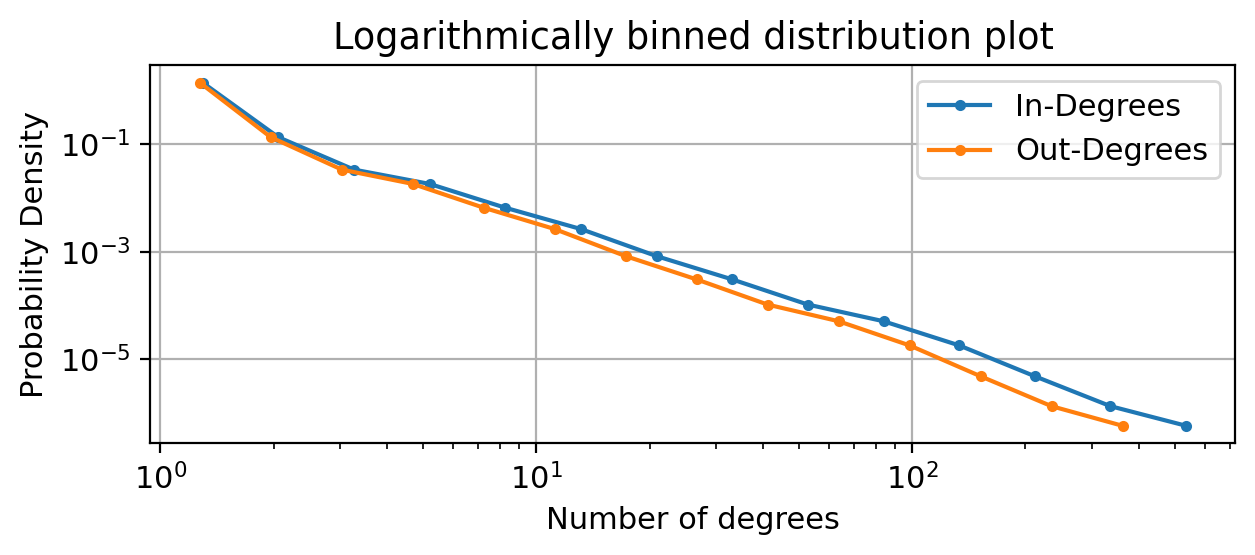

In [34]:
### Plot the distribution of in-degrees and out-degrees, using a logarithmic binning (see last week's exercise 4).

# Compute histogram
bins = np.logspace(0, np.log10(max(python_in_degrees)), 15)
hist, edges = np.histogram(python_in_degrees, bins=bins, density=True)
x_in = (edges[1:] + edges[:-1]) / 2.

bins = np.logspace(0, np.log10(max(python_out_degrees)), 15)
hist, edges = np.histogram(python_out_degrees, bins=bins, density=True)
x_out = (edges[1:] + edges[:-1]) / 2.

# Both in and out-degrees plot
fig, ax = plt.subplots()
ax.plot(x_in, hist, marker='.', label='In-Degrees')
ax.plot(x_out, hist, marker='.', label='Out-Degrees')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of degrees')
ax.set_ylabel('Probability Density')
ax.set_title("Logarithmically binned distribution plot")
ax.grid()
ax.legend(loc='upper right')
